# Calculate NLP statistics over classification results in excel format
Analyse a excel sheet of NLP classification results.

Use yaml config

In [1]:
use_config_file = True
config_file = './../resources/config/result-analysis-tn-t-train.yaml'
cfg = None
if use_config_file:
    import yaml
    with open(config_file, 'r') as yaml_file:
        cfg = yaml.safe_load(yaml_file)


Set path of excel sheet

In [2]:
path_excel_sheet = "./../resources/data_ignored/results-tn-val.xlsx"
if use_config_file:
    path_excel_sheet = cfg['path_excel_sheet']


Set output directory

In [3]:
path_output_dir = "./../resources/"

out_file = None
out_file_excel = None
if use_config_file:
    path_output_dir = cfg['path_output_dir']
try:
    from pathlib import Path
    Path(path_output_dir).mkdir(parents=True, exist_ok=True)
    out_file = open(path_output_dir + "/"+ "result-analysis-out.txt", "w")
    out_file_excel = path_output_dir + "/"+ "result-analysis-out.xlsx"
except OSError:
    print ("Creation of the directory %s failed" % path_output_dir)
else:
    print ("Successfully created the directory %s " % path_output_dir)
    

Successfully created the directory ./../resources/results/results-tn-t-train-results 


Set label and classification columns

In [4]:
column_actual = 'label longembolie'
column_predicted = 'target-snomedct:59282003'

if use_config_file:
    column_actual = cfg['column_actual']
    column_predicted = cfg['column_predicted']

Read columns and determine values, in case of key error, make sure the columns are set correctly

In [5]:
import pandas
df = pandas.read_excel(path_excel_sheet, header=0)

df = df[df["label_T"] != "?"] # Filter dataframe on reports that have a valid label
df = df[df["label_N"] != "?"] # Filter dataframe on reports that have a valid label

actual_values = df[column_actual].value_counts().index.tolist() 
predicted_values = df[column_predicted].value_counts().index.tolist() 

print('actual category values:', actual_values)
print('predicted category values:', predicted_values)
all_values = list(set(actual_values).union(set(predicted_values)))
print(all_values)

actual category values: ['T4', 'T2', 'T1', 'T3']
predicted category values: ['T2', 'T4', 'T1', 'T3', 'T0']
['T0', 'T3', 'T2', 'T1', 'T4']


Manually set valid values from actual and predicted categories (other values will be ignored)

In [6]:
valid_values = []
ignored_values = []

if use_config_file and 'valid_values' in cfg:
    valid_values = cfg['valid_values']
if use_config_file and 'ignored_values' in cfg:
    ignored_values = cfg['ignored_values']

if not valid_values or len(valid_values) == 0:
    valid_values = all_values
    
def matches_ignored(x):
    for ignored in ignored_values:
        if ignored in x:
            return True
    return False
    
valid_values = [] 
for x in all_values:
    if not matches_ignored(x):
        valid_values.append(x)

valid_values.sort()

Check valid values

In [7]:
df_valid = df[df[column_actual].isin(valid_values)]

actual_index_valid = df_valid[column_actual].value_counts().index.tolist() 
predicted_index_valid = df_valid[column_predicted].value_counts().index.tolist() 

print('actual category values:', actual_index_valid)
print('predicted category values:', predicted_index_valid)

actual category values: ['T4', 'T2', 'T1', 'T3']
predicted category values: ['T2', 'T4', 'T1', 'T3', 'T0']


Histograms Original

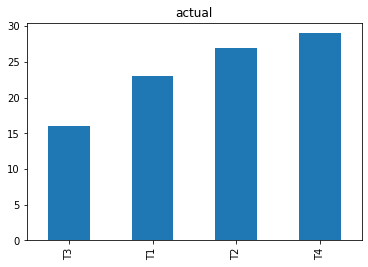

In [8]:
actual_bar_plt = df[column_actual].value_counts(sort = False).plot(kind='bar', title='actual')

Histograms Valid Values only

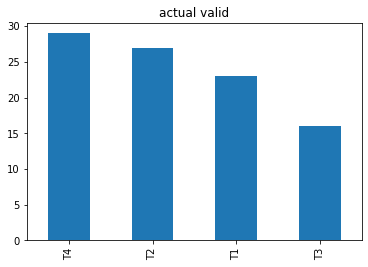

In [9]:
actual_valid_bar_plot = df_valid[column_actual].value_counts().plot(kind='bar', title='actual valid')

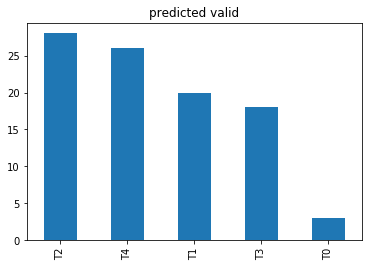

In [10]:
predicted_valid_bar_plt = df_valid[column_predicted].value_counts().plot(kind='bar', title='predicted valid')

Metrics

In [11]:
df = df_valid

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
y_actu = pandas.Series(df[column_actual], name='Actual')
y_pred = pandas.Series(df[column_predicted], name='Predicted')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

accuracy = "accuracy = " + str(round(accuracy_score(y_actu, y_pred), 4))
print(accuracy)
out_file.write(accuracy + "\n\n")

avg = ["micro", "macro", "weighted"]
for avg_opt in avg:
    a_precision = avg_opt + "_precision = " + str(round(precision_score(y_actu, y_pred, average=avg_opt), 4))
    a_recall_score = avg_opt + "_recall_score = " + str(round(recall_score(y_actu, y_pred, average=avg_opt), 4))
    a_f1 = avg_opt + "_f1 = " + str(round(f1_score(y_actu, y_pred, average=avg_opt), 4))
    print(a_precision)
    print(a_recall_score)
    print(a_f1)       
    out_file.write(a_precision + "\n")
    out_file.write(a_recall_score + "\n")
    out_file.write(a_f1 + "\n")
    out_file.write("\n")
    
from sklearn.metrics import precision_recall_fscore_support as score
predicted = [1,2,3,4,5,1,2,1,1,4,5] 

precision, recall, fscore, support = score(y_actu, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

out_file.write('precision: {}'.format(precision) + '\n')
out_file.write('recall: {}'.format(recall) +'\n')
out_file.write('fscore: {}'.format(fscore) + '\n')
out_file.write('support: {}'.format(support) + '\n')
print('\n')
               
prf = precision_recall_fscore_support(y_actu, y_pred, average=None, labels=valid_values)
evaldf = pandas.DataFrame({"Precision": prf[0], "Recall": prf[1], "F-score": prf[2]}, index=valid_values)
print(evaldf)
out_file.write(str(evaldf) + "\n\n")

accuracy = 0.8947
micro_precision = 0.8947
micro_recall_score = 0.8947
micro_f1 = 0.8947
macro_precision = 0.7381
macro_recall_score = 0.7185
macro_f1 = 0.7262
weighted_precision = 0.9313
weighted_recall_score = 0.8947
weighted_f1 = 0.9105
precision: [0.         1.         0.85714286 0.83333333 1.        ]
recall: [0.         0.86956522 0.88888889 0.9375     0.89655172]
fscore: [0.         0.93023256 0.87272727 0.88235294 0.94545455]
support: [ 0 23 27 16 29]


    Precision    Recall   F-score
T0   0.000000  0.000000  0.000000
T1   1.000000  0.869565  0.930233
T2   0.857143  0.888889  0.872727
T3   0.833333  0.937500  0.882353
T4   1.000000  0.896552  0.945455


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


205

Create confusion matrix

In [12]:
crosstab = pandas.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("CONFUSION MATRIX")
print(crosstab)
out_file.write(str(crosstab))


import openpyxl
crosstab.to_excel(out_file_excel)


CONFUSION MATRIX
Predicted  T0  T1  T2  T3  T4  All
Actual                            
T1          0  20   2   1   0   23
T2          2   0  24   1   0   27
T3          0   0   1  15   0   16
T4          1   0   1   1  26   29
All         3  20  28  18  26   95


Plot confusion matrix

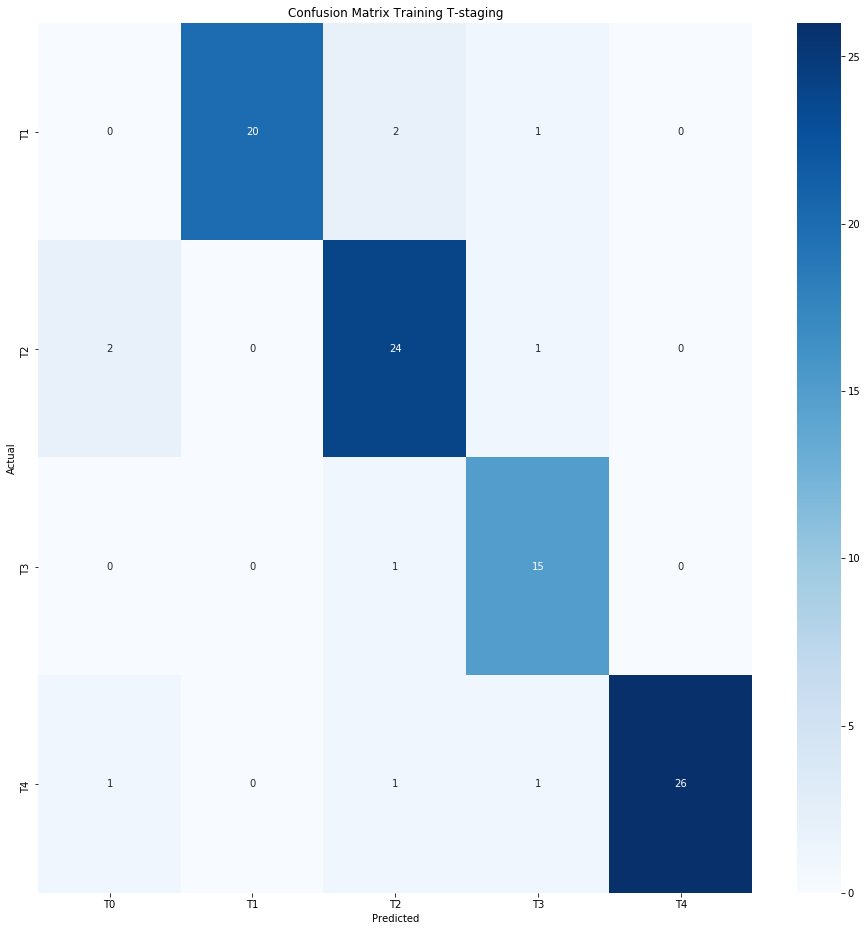

In [13]:
import seaborn
import matplotlib
import matplotlib.pyplot as plt

data = {'y_Actual': df_valid[column_actual], 'y_Predicted': df_valid[column_predicted]}
df = pandas.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pandas.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(16,16))  
plt.title(cfg['title_confusion_matrix'])

confusion_matrix_heatmap = seaborn.heatmap(confusion_matrix, annot=True, cmap=matplotlib.cm.Blues)



Save confusion matix figure to file

In [14]:
file_type_eps = False
fig = confusion_matrix_heatmap.get_figure()
if file_type_eps:
    fig.savefig(path_output_dir + "/" + "confusion_matrix.eps", dict="eps", dpi=200)
else:
   fig.savefig(path_output_dir + "/" + "confusion_matrix.png", dpi=200)

out_file.close()